In [2]:
import pandas as pd
import textstat

temps = [0.2, 0.5, 0.7]

for t in temps:
    # Define file paths
    input_path = f"Result_RQ2/{t}_desc_RQ2.csv"
    output_path = f"Result_RQ2/{t}_desc_RQ2_fog.csv"

    # Load CSV
    df = pd.read_csv(input_path)

    # Compute Gunning Fog Index for each description
    df['fog_index'] = df['Generated_Description'].apply(textstat.gunning_fog)

    # Group by Source and compute mean
    avg_fog_by_source = df.groupby('Source')['fog_index'].mean()

    # Print results
    print(f"\nTemperature {t}")
    for tier, value in avg_fog_by_source.items():
        print(f"Avg_Fog_{tier.capitalize()} = {value:.2f}")

    # Save results if needed
    df.to_csv(output_path, index=False)



Temperature 0.2
Avg_Fog_Bottom = 18.81
Avg_Fog_Middle = 18.11
Avg_Fog_Top = 16.85

Temperature 0.5
Avg_Fog_Bottom = 18.86
Avg_Fog_Middle = 18.14
Avg_Fog_Top = 16.89

Temperature 0.7
Avg_Fog_Bottom = 18.76
Avg_Fog_Middle = 18.19
Avg_Fog_Top = 16.95


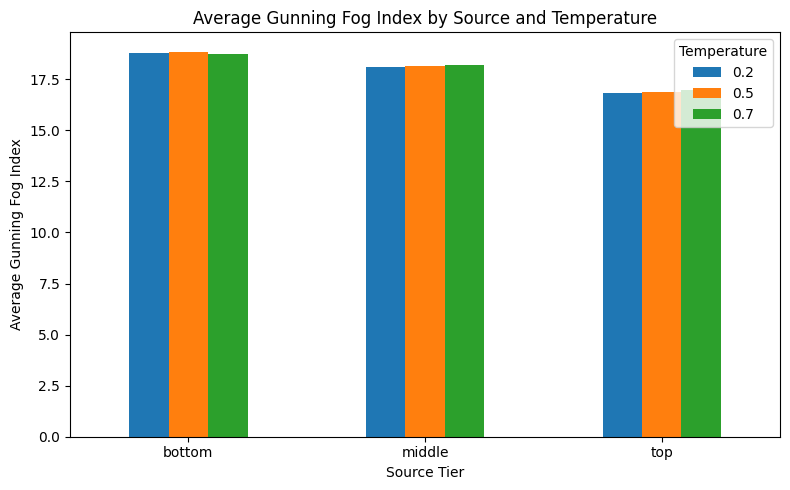

In [3]:
import pandas as pd
import textstat
import matplotlib.pyplot as plt

temps = [0.2, 0.5, 0.7]
fog_results = []

for t in temps:
    df = pd.read_csv(f"Result_RQ2/{t}_desc_RQ2.csv")
    df["fog_index"] = df["Generated_Description"].apply(textstat.gunning_fog)
    avg_fog = df.groupby("Source")["fog_index"].mean().reset_index()
    avg_fog["Temperature"] = t
    fog_results.append(avg_fog)

# Combine results
fog_df = pd.concat(fog_results)

# Pivot for visualization
pivot_df = fog_df.pivot(index="Source", columns="Temperature", values="fog_index")

# Plot
pivot_df.plot(kind="bar", figsize=(8,5))
plt.title("Average Gunning Fog Index by Source and Temperature")
plt.xlabel("Source Tier")
plt.ylabel("Average Gunning Fog Index")
plt.xticks(rotation=0)
plt.legend(title="Temperature")
plt.tight_layout()
plt.show()

